<a href="https://colab.research.google.com/github/skbetz54/Samuel_DATA606/blob/main/Notebooksk/EDA_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Analysis - Happyface**

This notebook does a baseline exploratory analysis for the dataset from [Hugging Face](https://huggingface.co/datasets/emotion) that classifies tweets as one of six different emotions: sadness, anger, love, joy, surprise, and fear. This notebook will start with preprocessing the dataset to allow ML libraries to better work with the text data. It is then followed by a few simple graphs to try and detect different vocabularies used within each tweet to gather how the dictionaries (lexicons) for each emotion are built, which are the basis of the model's application. For example, the word "scared" is much more likely to be used in a fearful tweet when compared to a joyful tweet. 

I'll start by importing the necessary Python libraries (for both the preprocessing and EDA), followed by creating a workable dataset and EDA.

In [ ]:
# Python library installations that do not come with Colab

!pip install contractions # used to get rid of contractions (in real-world news articles)
!pip install textblob # used for quantifying polarity of the tweets in the dataset.

# Library Imports

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
import pickle
import contractions

#Preprocessing Functions
from sklearn.utils import shuffle
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt') # punkt is a dependency used for nltk's  function "word_tokenize" that does not come when you import nltk
nltk.download('stopwords') # NLTK has a built-in dictionary of stop words that will be used when removing stopwords from the data
nltk.download('averaged_perceptron_tagger') # package that assigns parts of speech, to be used in lemmatization
nltk.download('wordnet') # Added because the above import from corpus sometimes does not work.
from nltk.tag import pos_tag # Another package used in lemmatization to import parts of speech for words

from wordcloud import WordCloud # EDA Tool
from textblob import TextBlob

from google.colab import files, drive

     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 287 kB 24.7 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Mounting my Google Drive to allow access. Again, this will be phased out to allow reproducibility of the code within the Github repository.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Part 1 - File Download**

This part will be changed eventually to make the code more reproducible, but for this iteration (1.0), I am uploading the text data directly from my Google Drive account. The download location can be found in the link above. 

In [ ]:
# Alternative way of opening the pickle file directly into Pandas (doesn't change anything)

path = "/content/gdrive/MyDrive/DATA606/Data/merged_training.pkl"

df = pd.read_pickle(path)

# The pickle file does not load the dataset in order of index, so I'm resetting the index and getting rid of the current one.
df.reset_index(inplace = True) #resetting index
df.drop('index', inplace = True, axis=1) # Getting rid of old 'index' column

df.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [ ]:
print("Column Names:\n")
print(df.columns)
print("Shape of the dataset:\n")
print(df.shape)
print("\nFirst 5 rows:")
df.head()

Column Names:

Index(['text', 'emotions'], dtype='object')
Shape of the dataset:

(416809, 2)

First 5 rows:


,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [ ]:
# Changing the data type of the text data from "object" to "string"

df['text'] = df['text'].astype('str')
"""
--------------------------------------
Categorical variables are impossible to work with machine learning algorithms; I need to transform the nominal variables of emotion
into a format that is workable within our ML model.
Building two dictionaries to easily transfer the different classes between ASCII characters and integers. Emotions are broken down as follows:
1. fear - 0 
2. anger - 1
3. sadness - 2
4. joy - 3
5. love - 4
6. surprise - 5
--------------------------------------
"""

classes_eng = ["fear", "anger", "sadness", "joy", "love", "surprise"]

classes_to_num = {classes_eng[i]:i for i in range(len(classes_eng))}
num_to_classes = {i:classes_eng[i] for i in range(len(classes_eng))}

print(classes_to_num)
print(num_to_classes)

# Adding a class column using the above dictionaries
df['class'] = df['emotions'].map(classes_to_num)

#Sanity check to ensure that the classes_to_num dictionary was correctly mapped.
df.head()

{'fear': 0, 'anger': 1, 'sadness': 2, 'joy': 3, 'love': 4, 'surprise': 5}
{0: 'fear', 1: 'anger', 2: 'sadness', 3: 'joy', 4: 'love', 5: 'surprise'}


,text,emotions,tokenized_text,no_stopwords,no_stopwords_additional,class
0,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ...","[feel, awful, job, get, position, succeed, hap...","[awful, job, position, succeed, happen]",2
1,im alone i feel awful,sadness,"[im, alone, i, feel, awful]","[alone, feel, awful]","[alone, awful]",2
2,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, feel, proud, act...","[probably, mentioned, proud, actually, keeping...",3
3,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]","[little, low, days, back]",2
4,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ...","[beleive, much, sensitive, peoples, feelings, ...",4


In [ ]:
# Adding second class "pos_or_neg" that will only determine whether the tweet is positive (if it is love, joy, or surprise) or negative. 

def pos_neg(row):
  negative = ['fear', 'sadness','anger']

  if row['emotions'] in negative:
    emotion = "negative"
  else: 
    emotion = 'positive'
  return emotion


df['pos_or_neg'] = df.apply(lambda x: pos_neg(x), axis = 1)

df.head()

,text,emotions,class,pos_or_neg
0,i feel awful about it too because it s my job ...,sadness,2,negative
1,im alone i feel awful,sadness,2,negative
2,ive probably mentioned this before but i reall...,joy,3,positive
3,i was feeling a little low few days back,sadness,2,negative
4,i beleive that i am much more sensitive to oth...,love,4,positive


## **Part 2 - Text Preprocessing**

Luckily, for this initial dataset, there is not the amount of text preprocessing that is typically required for tweets and sentences as some of the work has already been done by the dataset's authors. This includes:
1. Removing punctuation
2. Removing contractions (words with apostrophes)
3. Sending the text to lowercase

Below I will still be dedicating a couple cells for these problems because this **will** have to be done for the news articles when I shift my project to that. I will test out these solutions on sample sentences that include these problems.


In [ ]:
# Functions for later (not needed for HappyFace). 

def remove_contractions(text):
  """
  --------------------------------------
  Function for removing contractions (such as don't, won't, etc.) from the text data in the
  pandas dataframe. Luckily there is a library already available for this option... contractions.
  Using contractions.fix(text), I can easily do this.
  --------------------------------------
  """
  import contractions
  newtext = contractions.fix(text)
  return newtext

#Removing Punctuation

def remove_punc(text):
  """
  --------------------------------------
  This function will take an input string (word, sentence, paragraph, etc.), and return the same string
  WITHOUT any punctuation marks. To do this we use regular expressions (regex for short) Particularly the built-in 
  method "sub", which takes any specified regex expression and replaces it with whatever you want. For this exaple
  we use the expression [^\w\s], which is the opposite of [\w\s], which looks for all whitespaces and words.
  Thus, this function will look for anything that is NOT a word or whitespace and replace it with nothing (""). 
  
  Note that if this is run before the function above "remove_contractions", it will make the function unworkable, 
  so this will ALWAYS be run after "remove_contractions".
  --------------------------------------
  """
  import re
  newtext = re.sub(r'[^\w\s]','', text)
  return newtext


# Making everything lowercase

def lowercase_text(text):
  """
  --------------------------------------
  A simple function to make all letters in a text lowercase. It is only in a function to be reusable for other notebooks.
  --------------------------------------
  """
  newtext = text.lower()
  return newtext

In [ ]:
# Testing the above code on sample sentences

sentence = "I Don't %%$want to [] go Out TO the BALLgame!"
print("Original Text:\n" + sentence)
newsentence = remove_contractions(sentence)
print("\nText without contractions:\n" + newsentence)
newsentence = remove_punc(newsentence)
print("\nText without punctuation:\n"+newsentence)
newsentence = lowercase_text(newsentence)
print("\nAll lowercase text:\n" + newsentence)

Original Text:
I Don't %%$want to [] go Out TO the BALLgame!

Text without contractions:
I Do not %%$want to [] go Out TO the BALLgame!

Text without punctuation:
I Do not want to  go Out TO the BALLgame

All lowercase text:
i do not want to  go out to the ballgame


There are still several steps necessary for cleaning this text data that will be required for all text in this project before I can continue with this current EDA. They are:

1. **Removing stop words** - words such as "I", "the", "and", and others that do not add much information to the overall sentiment of the text. Therefore removing them from our individual tweets are beneficial.
3. **Tokenization** - Tokenization breaks down a phrase/sentence/paragraph/etc. into a simple format, in this case words, to allow the machine to better handle. Each sentence is then represented as a vector of tokens. 
3. **Stemming** - The same word can come in many different formats, such as "played", "plays", and "playing". Stemming removes these endings or "stems" from each word. 
4. **Lemmatization** - A similar but more robust strategy to stemming, which takes away the ending stems of words. However, lemmatization uses context of words instead of just looking for standard endings. For example, stemming would transform the word "ring" into just "r", whereas lemmatization allows the word to exist in full because the "ing" is not the present participle of "r". **For this reason, lemmatization is used for this project**


In [ ]:
# Tokenizing 
"""
--------------------------------------
Like most of the data cleaning done for NLP, we will be utilizing the Natural Language
Tool Kit, or NLTK for short. NLTK has many built in libraries, methods, and functions that allow
for easier preprocessing. The first step is to tokenize the data and create vectors of the words. 
--------------------------------------
"""

df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis = 1)

df.head()

,text,emotions,tokenized_text
0,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ..."
1,im alone i feel awful,sadness,"[im, alone, i, feel, awful]"
2,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ..."
3,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b..."
4,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv..."


In [ ]:
# Removing Stop Words 
"""
--------------------------------------
Now that each tweet has been tokenized, I am going to remove the stop words throughout the dataset.
each tweet. Each word will be an individual vector that can 
be quantified and analyzed.
--------------------------------------
"""

stop_words = set(stopwords.words('english')) # Declaring only english words as the ones that we want to use

# Because huggingface has already gotten rid of contractions, I need to add some common contractions WITHOUT the apostrophe so they are still recognized
# NOTE: This will likely not be required in real-world text since the incoming text will not be partially cleaned already.
cont_no_apostrophe = ['dont','id','im','ive','ill','shouldve','couldve','arent','its','itll','itd','thats','thatd','whod','youve','were',
                      'whod','whats','theyre','theres','thered']
# Adding above words to the set
for word in cont_no_apostrophe:
  stop_words.add(word)


df['no_stopwords'] = df['tokenized_text'] # Copying our previous step into a new one

# Finally applying a function to remove all of the 
df['no_stopwords'] = df['no_stopwords'].apply(lambda x:[word for word in x if word not in stop_words])

df.head()




,text,emotions,tokenized_text,no_stopwords
0,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ...","[feel, awful, job, get, position, succeed, hap..."
1,im alone i feel awful,sadness,"[im, alone, i, feel, awful]","[alone, feel, awful]"
2,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, feel, proud, act..."
3,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]"
4,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ..."


In [ ]:
# Word lemmatization
"""
--------------------------------------
Our last step in preprocessing this text data is adding on to our already completed steps and 
casting different forms of words to their root word. As mentioned above, lemmatizing is a slightly more
complicated process than stemming because it will take into account the PART OF SPEECH of each word.
Thus, there are a couple steps to complete. First I assign parts of speech to 
each word. Next, because I'm using NLTK and the associated wordnet with the lemmatizer, I have to convert
the parts of speech in the format acceptable for wordnet to use.
--------------------------------------
"""

df['part_of_speech'] = df['no_stopwords'].apply(nltk.tag.pos_tag) # Using nltk's built in "pos_tag" to add parts of speech for each token (word)

df.head()

"\n--------------------------------------\nOur last step in preprocessing this text data is adding on to our already completed steps and \ncasting different forms of words to their root word. As mentioned above, lemmatizing is a slightly more\ncomplicated process than stemming because it will take into account the PART OF SPEECH of each word.\nThus, there are a couple steps to complete. First I assign parts of speech to \neach word. Next, because I'm using NLTK and the associated wordnet with the lemmatizer, I have to convert\nthe parts of speech in the format acceptable for wordnet to use.\n--------------------------------------\n"

In [ ]:
"""
--------------------------------------
As we see above, the "part_of_speech" column now contains tuples with both the word and the part of speech. 
However, for our lemmatizer we need to transform these parts of speech into things that nltk's wordnet can recognize.
Therefore I create a function 'wordnet_tagger' (taken from https://www.holisticseo.digital/python-seo/nltk/lemmatize)
to allow this to happen.
--------------------------------------
"""
#Helper function to transform the parts of speech into 
def wordnet_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN # This part was changed from 'return NONE' because there are several other tags found here not in the above categories, which will be changed to nouns

# Creating new column for the wordnet part of speech to use, applying the above function
df['wn_part_of_speech'] = df['part_of_speech'].apply(lambda x: [(word, wordnet_tagger(pos_tag)) for (word, pos_tag) in x])

df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech
0,i feel awful about it too because it s my job ...,sadness,2,negative,"[i, feel, awful, about, it, too, because, it, ...","[feel, awful, job, get, position, succeed, hap...","[(feel, VB), (awful, JJ), (job, NN), (get, VB)...","[(feel, v), (awful, a), (job, n), (get, v), (p..."
1,im alone i feel awful,sadness,2,negative,"[im, alone, i, feel, awful]","[alone, feel, awful]","[(alone, RB), (feel, NN), (awful, JJ)]","[(alone, r), (feel, n), (awful, a)]"
2,ive probably mentioned this before but i reall...,joy,3,positive,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, feel, proud, act...","[(probably, RB), (mentioned, VBN), (really, RB...","[(probably, r), (mentioned, v), (really, r), (..."
3,i was feeling a little low few days back,sadness,2,negative,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]","[(feeling, VBG), (little, JJ), (low, JJ), (day...","[(feeling, v), (little, a), (low, a), (days, n..."
4,i beleive that i am much more sensitive to oth...,love,4,positive,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ...","[(beleive, JJ), (much, RB), (sensitive, JJ), (...","[(beleive, a), (much, r), (sensitive, a), (peo..."


In [ ]:
"""
--------------------------------------
Finally we can apply the parts of speech and words to our word lemmatizer using 
NLTK's WordNetLemmatizer again by applying the 'wn_part_of_speech' tuples with my lemmatizer
--------------------------------------
"""

lemmatizer = WordNetLemmatizer()

df['lemmatized'] = df['wn_part_of_speech'].apply(lambda x: [lemmatizer.lemmatize(word, pos) for word, pos in x])
df.head()


,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized
0,i feel awful about it too because it s my job ...,sadness,2,negative,"[i, feel, awful, about, it, too, because, it, ...","[feel, awful, job, get, position, succeed, hap...","[(feel, VB), (awful, JJ), (job, NN), (get, VB)...","[(feel, v), (awful, a), (job, n), (get, v), (p...","[feel, awful, job, get, position, succeed, hap..."
1,im alone i feel awful,sadness,2,negative,"[im, alone, i, feel, awful]","[alone, feel, awful]","[(alone, RB), (feel, NN), (awful, JJ)]","[(alone, r), (feel, n), (awful, a)]","[alone, feel, awful]"
2,ive probably mentioned this before but i reall...,joy,3,positive,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, feel, proud, act...","[(probably, RB), (mentioned, VBN), (really, RB...","[(probably, r), (mentioned, v), (really, r), (...","[probably, mention, really, feel, proud, actua..."
3,i was feeling a little low few days back,sadness,2,negative,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]","[(feeling, VBG), (little, JJ), (low, JJ), (day...","[(feeling, v), (little, a), (low, a), (days, n...","[feel, little, low, day, back]"
4,i beleive that i am much more sensitive to oth...,love,4,positive,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ...","[(beleive, JJ), (much, RB), (sensitive, JJ), (...","[(beleive, a), (much, r), (sensitive, a), (peo...","[beleive, much, sensitive, people, feeling, te..."


In [ ]:
# Creating a single string from the lemmatized subset of tokens

df['lemma_string'] = [' '.join(map(str,l)) for l in df['lemmatized']]
df['lemma_string'] = df['lemma_string'].apply(lambda x: str.lower(x))

In [ ]:
"""
--------------------------------------
I'm now adding one more column to the dataset, "sentiment", which is a NLP tool to 
measure the polarity of a document. The polarity ranges on a scale from -1 (extremely negative)
to 1 (extremely positive). This will allow us to visualize the varying sentiment 
across the different emotions. 
--------------------------------------
"""

df['sentiment'] = df['lemma_string'].apply(lambda x: TextBlob(x).sentiment.polarity)

df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment
0,i feel awful about it too because it s my job ...,sadness,2,negative,"[i, feel, awful, about, it, too, because, it, ...","[feel, awful, job, get, position, succeed, hap...","[(feel, VB), (awful, JJ), (job, NN), (get, VB)...","[(feel, v), (awful, a), (job, n), (get, v), (p...","[feel, awful, job, get, position, succeed, hap...",feel awful job get position succeed happen,-1.000000
1,im alone i feel awful,sadness,2,negative,"[im, alone, i, feel, awful]","[alone, feel, awful]","[(alone, RB), (feel, NN), (awful, JJ)]","[(alone, r), (feel, n), (awful, a)]","[alone, feel, awful]",alone feel awful,-1.000000
2,ive probably mentioned this before but i reall...,joy,3,positive,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, feel, proud, act...","[(probably, RB), (mentioned, VBN), (really, RB...","[(probably, r), (mentioned, v), (really, r), (...","[probably, mention, really, feel, proud, actua...",probably mention really feel proud actually ke...,0.284091
3,i was feeling a little low few days back,sadness,2,negative,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]","[(feeling, VBG), (little, JJ), (low, JJ), (day...","[(feeling, v), (little, a), (low, a), (days, n...","[feel, little, low, day, back]",feel little low day back,-0.062500
4,i beleive that i am much more sensitive to oth...,love,4,positive,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ...","[(beleive, JJ), (much, RB), (sensitive, JJ), (...","[(beleive, a), (much, r), (sensitive, a), (peo...","[beleive, much, sensitive, people, feeling, te...",beleive much sensitive people feeling tend com...,0.100000


In [ ]:
# Adding word length for machine learning purposes

df['word_length'] = df['lemma_string'].apply(lambda row: len(str(row).split(sep = " ")))

df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment,word_length
0,i feel awful about it too because it s my job ...,sadness,2,negative,"[i, feel, awful, about, it, too, because, it, ...","[feel, awful, job, get, position, succeed, hap...","[(feel, VB), (awful, JJ), (job, NN), (get, VB)...","[(feel, v), (awful, a), (job, n), (get, v), (p...","[feel, awful, job, get, position, succeed, hap...",feel awful job get position succeed happen,-1.000000,7
1,im alone i feel awful,sadness,2,negative,"[im, alone, i, feel, awful]","[alone, feel, awful]","[(alone, RB), (feel, NN), (awful, JJ)]","[(alone, r), (feel, n), (awful, a)]","[alone, feel, awful]",alone feel awful,-1.000000,3
2,ive probably mentioned this before but i reall...,joy,3,positive,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, feel, proud, act...","[(probably, RB), (mentioned, VBN), (really, RB...","[(probably, r), (mentioned, v), (really, r), (...","[probably, mention, really, feel, proud, actua...",probably mention really feel proud actually ke...,0.284091,13
3,i was feeling a little low few days back,sadness,2,negative,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]","[(feeling, VBG), (little, JJ), (low, JJ), (day...","[(feeling, v), (little, a), (low, a), (days, n...","[feel, little, low, day, back]",feel little low day back,-0.062500,5
4,i beleive that i am much more sensitive to oth...,love,4,positive,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ...","[(beleive, JJ), (much, RB), (sensitive, JJ), (...","[(beleive, a), (much, r), (sensitive, a), (peo...","[beleive, much, sensitive, people, feeling, te...",beleive much sensitive people feeling tend com...,0.100000,7


## **Part 2.1 - Dataframe Subsetting**

To help with some of the EDA below, especially to see how each emotion works, I am creating individual dataframes for each class (emotion).

In [ ]:
# Fear Dataset
df_fear = df[df['class']==0]
df_fear.reset_index(inplace = True) #resetting index
df_anger = df[df['class']==1]
df_anger.reset_index(inplace = True) #resetting index
df_sadness = df[df['class']==2]
df_sadness.reset_index(inplace = True) #resetting index
df_joy = df[df['class']==3]
df_joy.reset_index(inplace = True) #resetting index
df_love = df[df['class']==4]
df_love.reset_index(inplace = True) #resetting index
df_surprise = df[df['class']==5]
df_surprise.reset_index(inplace = True) #resetting index

## **Part 3 - Exploratory Data Analysis**

Now that we have our Huggingface data in working order, we can start to examine the dataset. Most of the EDA will be focused on comparing the different emotions, by both word frequency and tweet polarity.

In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned.csv"


df = pd.read_csv(save_path)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment
0,i feel awful about it too because it s my job ...,sadness,2,negative,"['i', 'feel', 'awful', 'about', 'it', 'too', '...","['feel', 'awful', 'job', 'get', 'position', 's...","[('feel', 'VB'), ('awful', 'JJ'), ('job', 'NN'...","[('feel', 'v'), ('awful', 'a'), ('job', 'n'), ...","['feel', 'awful', 'job', 'get', 'position', 's...",feel awful job get position succeed happen,-1.000000
1,im alone i feel awful,sadness,2,negative,"['im', 'alone', 'i', 'feel', 'awful']","['alone', 'feel', 'awful']","[('alone', 'RB'), ('feel', 'NN'), ('awful', 'J...","[('alone', 'r'), ('feel', 'n'), ('awful', 'a')]","['alone', 'feel', 'awful']",alone feel awful,-1.000000
2,ive probably mentioned this before but i reall...,joy,3,positive,"['ive', 'probably', 'mentioned', 'this', 'befo...","['probably', 'mentioned', 'really', 'feel', 'p...","[('probably', 'RB'), ('mentioned', 'VBN'), ('r...","[('probably', 'r'), ('mentioned', 'v'), ('real...","['probably', 'mention', 'really', 'feel', 'pro...",probably mention really feel proud actually ke...,0.284091
3,i was feeling a little low few days back,sadness,2,negative,"['i', 'was', 'feeling', 'a', 'little', 'low', ...","['feeling', 'little', 'low', 'days', 'back']","[('feeling', 'VBG'), ('little', 'JJ'), ('low',...","[('feeling', 'v'), ('little', 'a'), ('low', 'a...","['feel', 'little', 'low', 'day', 'back']",feel little low day back,-0.062500
4,i beleive that i am much more sensitive to oth...,love,4,positive,"['i', 'beleive', 'that', 'i', 'am', 'much', 'm...","['beleive', 'much', 'sensitive', 'peoples', 'f...","[('beleive', 'JJ'), ('much', 'RB'), ('sensitiv...","[('beleive', 'a'), ('much', 'r'), ('sensitive'...","['beleive', 'much', 'sensitive', 'people', 'fe...",beleive much sensitive people feeling tend com...,0.100000


In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned.csv"


df = pd.read_csv(save_path)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment
0,i feel awful about it too because it s my job ...,sadness,2,negative,"['i', 'feel', 'awful', 'about', 'it', 'too', '...","['feel', 'awful', 'job', 'get', 'position', 's...","[('feel', 'VB'), ('awful', 'JJ'), ('job', 'NN'...","[('feel', 'v'), ('awful', 'a'), ('job', 'n'), ...","['feel', 'awful', 'job', 'get', 'position', 's...",feel awful job get position succeed happen,-1.000000
1,im alone i feel awful,sadness,2,negative,"['im', 'alone', 'i', 'feel', 'awful']","['alone', 'feel', 'awful']","[('alone', 'RB'), ('feel', 'NN'), ('awful', 'J...","[('alone', 'r'), ('feel', 'n'), ('awful', 'a')]","['alone', 'feel', 'awful']",alone feel awful,-1.000000
2,ive probably mentioned this before but i reall...,joy,3,positive,"['ive', 'probably', 'mentioned', 'this', 'befo...","['probably', 'mentioned', 'really', 'feel', 'p...","[('probably', 'RB'), ('mentioned', 'VBN'), ('r...","[('probably', 'r'), ('mentioned', 'v'), ('real...","['probably', 'mention', 'really', 'feel', 'pro...",probably mention really feel proud actually ke...,0.284091
3,i was feeling a little low few days back,sadness,2,negative,"['i', 'was', 'feeling', 'a', 'little', 'low', ...","['feeling', 'little', 'low', 'days', 'back']","[('feeling', 'VBG'), ('little', 'JJ'), ('low',...","[('feeling', 'v'), ('little', 'a'), ('low', 'a...","['feel', 'little', 'low', 'day', 'back']",feel little low day back,-0.062500
4,i beleive that i am much more sensitive to oth...,love,4,positive,"['i', 'beleive', 'that', 'i', 'am', 'much', 'm...","['beleive', 'much', 'sensitive', 'peoples', 'f...","[('beleive', 'JJ'), ('much', 'RB'), ('sensitiv...","[('beleive', 'a'), ('much', 'r'), ('sensitive'...","['beleive', 'much', 'sensitive', 'people', 'fe...",beleive much sensitive people feeling tend com...,0.100000


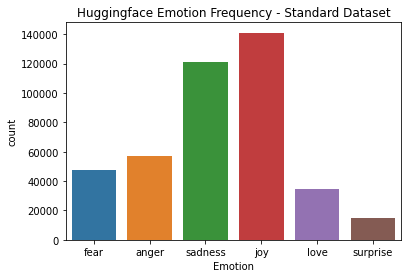

In [ ]:
ax = sns.countplot(x='class', data=df)
# ax.set(xlabel=num_to_classes,
#        title='Frequency of Emotions - Huggingface')

ax.set_xticklabels(num_to_classes.values())
ax.set_xlabel("Emotion")
ax.set(title='Frequency of Emotions - Huggingface')
ax.set(title='Huggingface Emotion Frequency - Standard Dataset')

plt.show()

## **Part 3.1 - Word Frequency Counts**

Below I do an analysis on the frequency of different words being used in the dataset, and for each emotion. I'll plot the top 10 words for each set, and then using the wordcloud library, create a word cloud of more words being used.

This can be a good way to see words that are associated with each emotion, but it is also a good chance to see if there are any words that should be added to our set of stopwords (in part 2). For example, if there's a word appearing high on the list in each of the emotion, it may be a good idea to not include those in our analysis. 

In [ ]:
# a = df_subset['lemma_string'].str.split(expand=True).stack().value_counts()
"""
--------------------------------------
Below is a simple way to get the counts of all the words being used in each of the datasets. 
We take the string version of the lemmatized tweets, split them by the whitespace to capture each word 
individually (expand = True is used to put the separated strings into separate columns so stack can work),
then stacking the words back into a single column, and finally taking a value count of the words.
--------------------------------------

"""
# Below is a simple way to get the counts of all the words being used in each of the datasets. 
count_full = df['lemma_string'].str.split(expand=True).stack().value_counts()
count_fear = df_fear['lemma_string'].str.split(expand=True).stack().value_counts()
count_anger = df_anger['lemma_string'].str.split(expand=True).stack().value_counts()
count_sadness = df_sadness['lemma_string'].str.split(expand=True).stack().value_counts()
count_joy = df_joy['lemma_string'].str.split(expand=True).stack().value_counts()
count_love = df_love['lemma_string'].str.split(expand=True).stack().value_counts()
count_surprised = df_surprise['lemma_string'].str.split(expand=True).stack().value_counts()

**NOTE:** 

The below plots (other than the entire dataset plot) are actually the 11th through 21st most popular used words because the top 10 words are all similar across each subset. 

In [ ]:
# Setting colors manually for 10 values (Taken from the documentation https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

cols = ['darkgreen','green','forestgreen','seagreen','lime','springgreen','lightseagreen','turquoise','cyan','aquamarine']

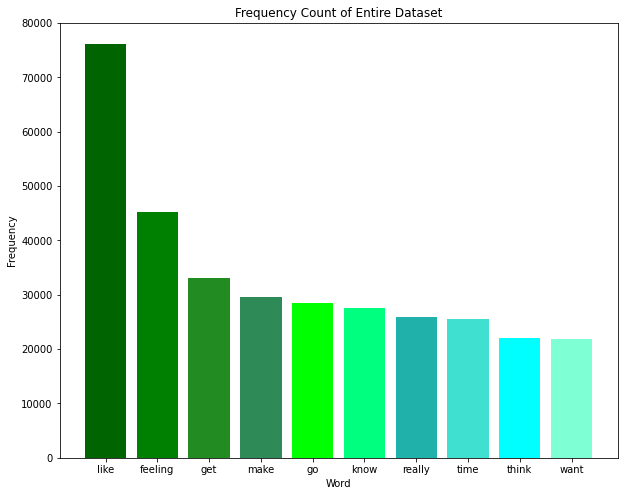

In [ ]:
# Frequency plot of ENTIRE DATASET

plt.figure(figsize=(10,8))
plt.bar(count_full[1:11].index, count_full[1:11].values, color=cols)
plt.title("Frequency Count of Entire Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

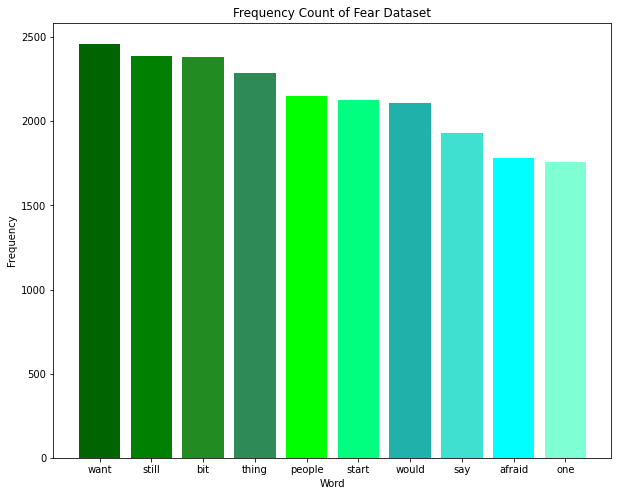

In [ ]:
# Frequency plot of FEAR DATASET

plt.figure(figsize=(10,8))
plt.bar(count_fear[11:21].index, count_fear[11:21].values, color=cols)
plt.title("Frequency Count of Fear Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

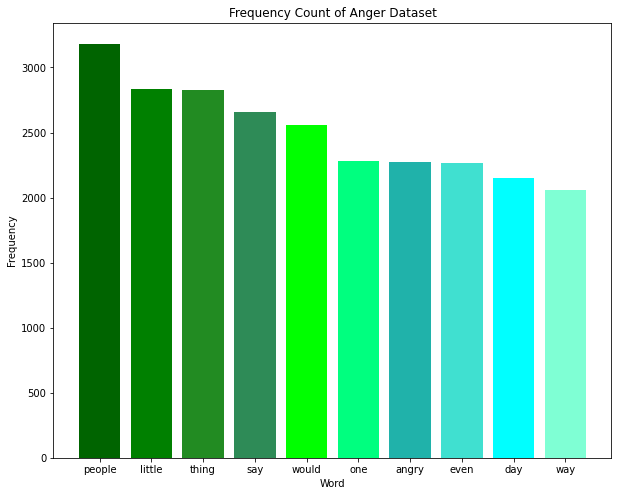

In [ ]:
# Frequency plot of ANGER DATASET

plt.figure(figsize=(10,8))
plt.bar(count_anger[11:21].index, count_anger[11:21].values, color=cols)
plt.title("Frequency Count of Anger Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

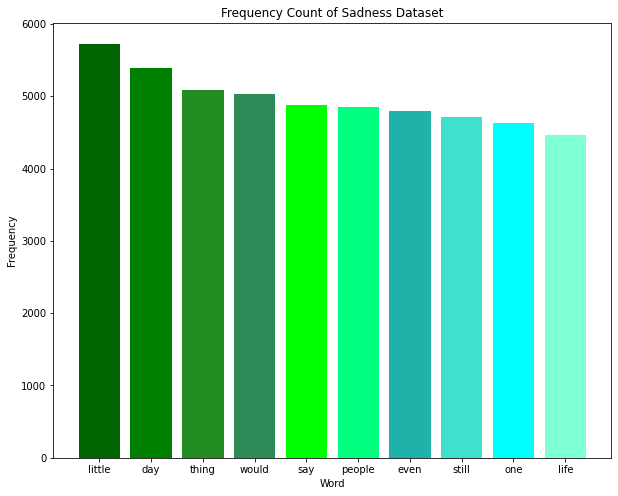

In [ ]:
# Frequency plot of SADNESS DATASET

plt.figure(figsize=(10,8))
plt.bar(count_sadness[11:21].index, count_sadness[11:21].values, color=cols)
plt.title("Frequency Count of Sadness Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

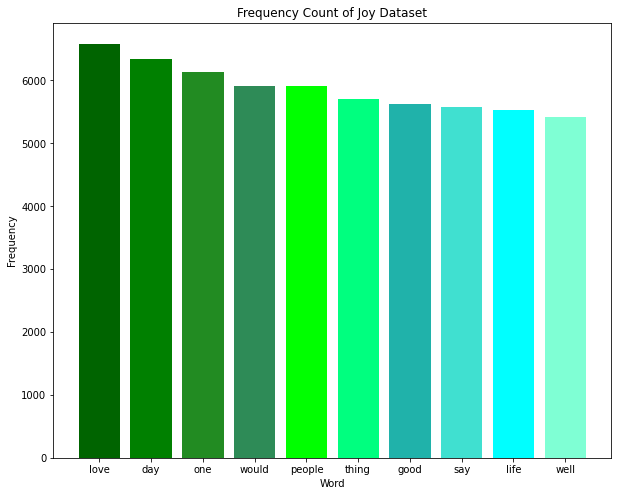

In [ ]:
# Frequency plot of JOY DATASET

plt.figure(figsize=(10,8))
plt.bar(count_joy[11:21].index, count_joy[11:21].values, color=cols)
plt.title("Frequency Count of Joy Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

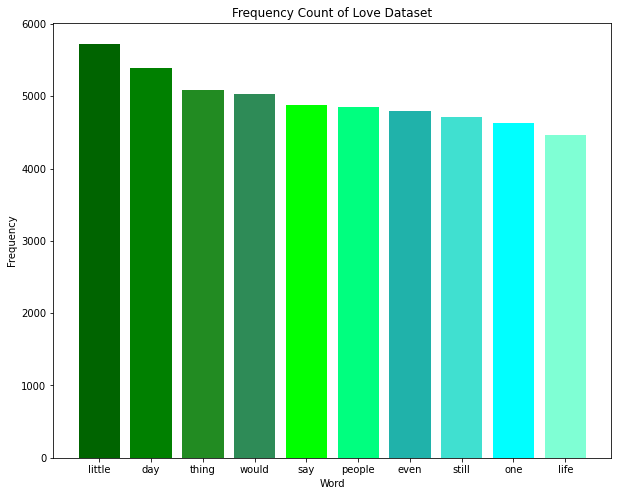

In [ ]:
# Frequency plot of LOVE DATASET

plt.figure(figsize=(10,8))
plt.bar(count_sadness[11:21].index, count_sadness[11:21].values, color=cols)
plt.title("Frequency Count of Love Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

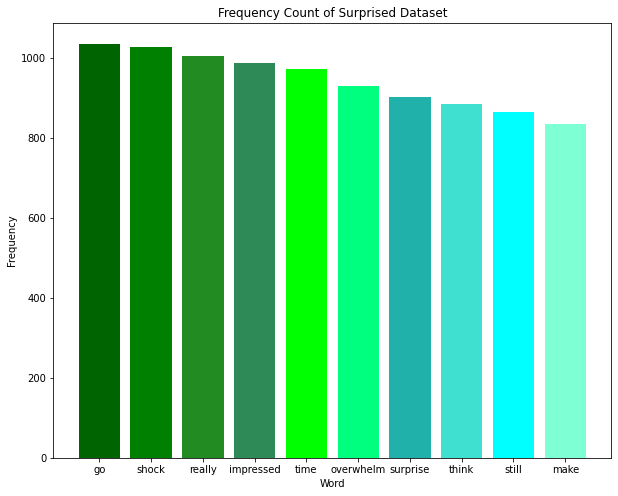

In [ ]:
# Frequency plot of SURPRISED DATASET

plt.figure(figsize=(10,8))
plt.bar(count_surprised[11:21].index, count_surprised[11:21].values, color=cols)
plt.title("Frequency Count of Surprised Dataset")
plt.xlabel('Word')
plt.ylabel("Frequency")

plt.show()

**ANALYSIS:**

With most of the top 10 words being the same across each emotion, I was expecting to find some higher counts of words that match the emotion, but other than "surprised", this wasn't really the case. Most of the emotions have only 1 or 2 words that match the emotion (fear --> afraid, anger --> angry). 

## **Part 3.2 - Word Clouds**

I am now going to expand the number of words being considered to see if the words used for each emotion change. I will not do the entire dataset, because since joy has much more samples, those words will likely skew the wordcloud to those. I consider the top 100 (past the top 10, so rank 11-111) for each emotion below.

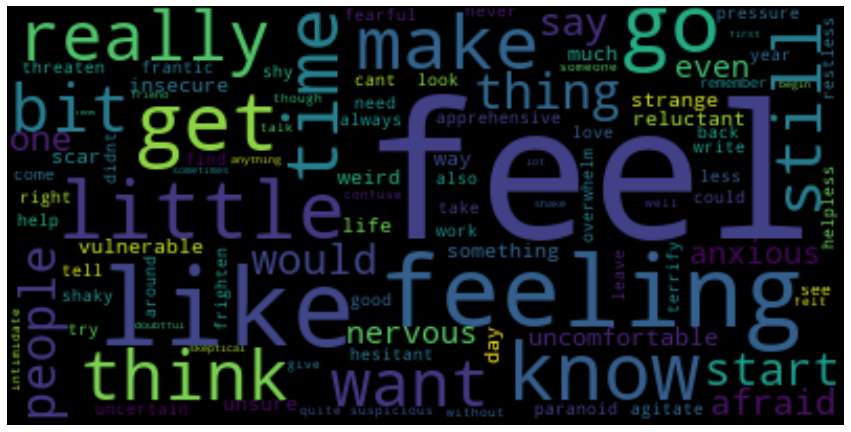

In [ ]:

"""
--------------------------------------
Wordcloud is a library that allows you to create the images shown below. I will be using the value_counts series made above.
All one has to do is create a 'wordcloud' object with the given parameters, and use matplotlib's imshow to display the image.
The original WordCloud class expects an uninterrupted string, but since I already have the counts I can use the classes function
"generate_from_frequencies" on the dictionary-version of the value counts.
--------------------------------------
"""
# Full Dataset

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_fear.to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

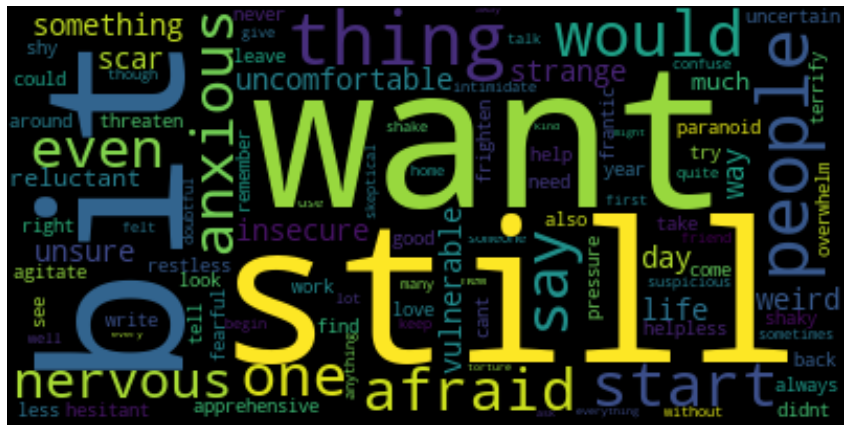

In [ ]:
# FEAR 

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_fear[11:].to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

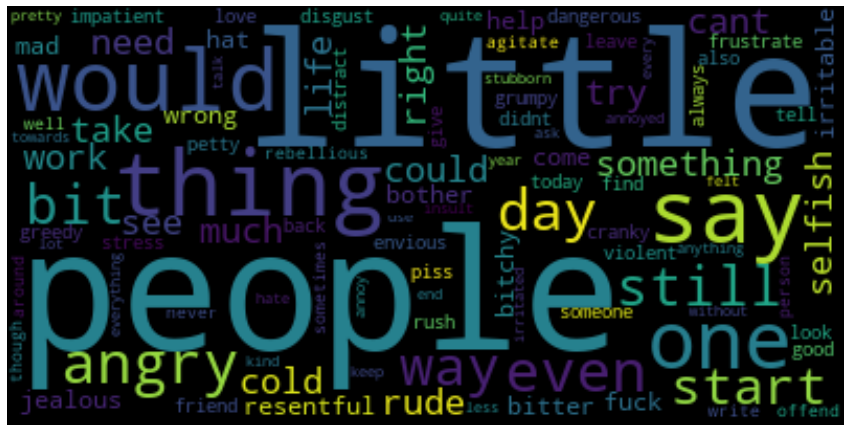

In [ ]:
# ANGER

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_anger[11:].to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

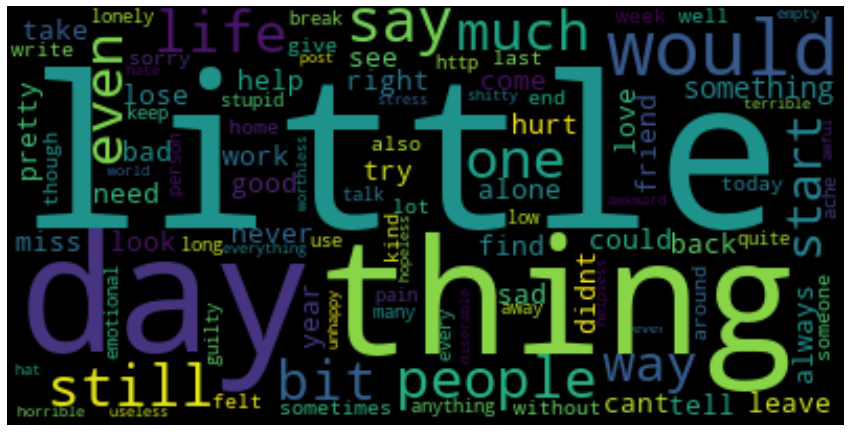

In [ ]:
# SADNESS

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_sadness[11:].to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

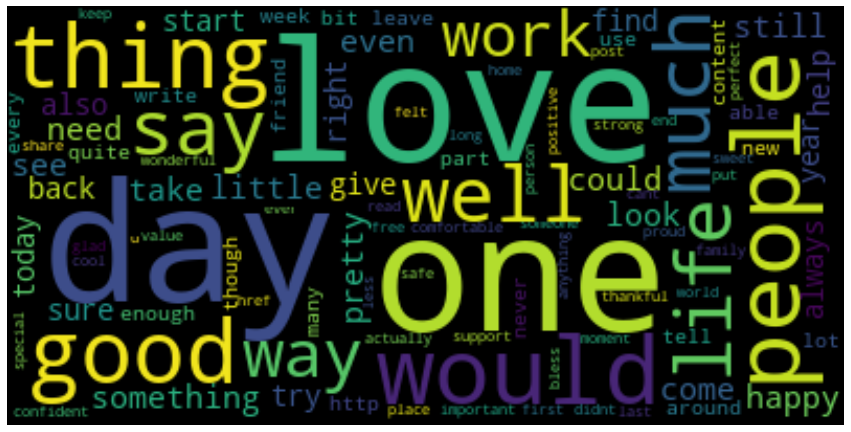

In [ ]:
# JOY

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_joy[11:].to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

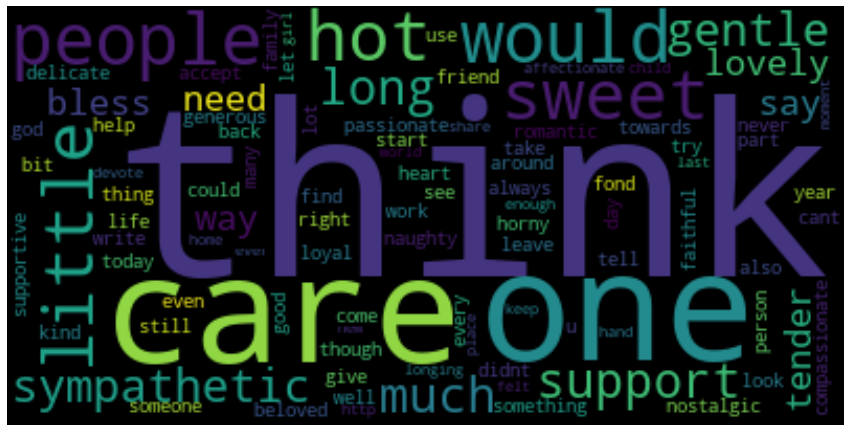

In [ ]:
# LOVE

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_love[11:].to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

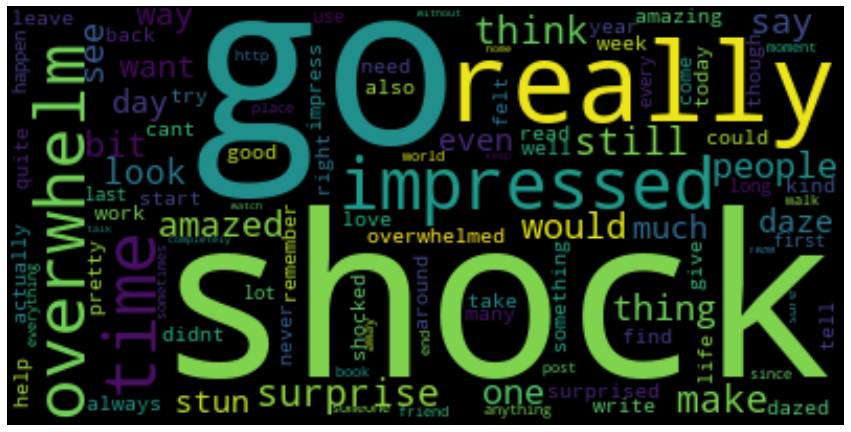

In [ ]:
# SURPRISED

wordcloud = WordCloud(max_words = 100).generate_from_frequencies(count_surprised[11:].to_dict())

plt.figure(figsize = (15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Part 3.3 Text Polarity**

While my project focuses on sentiment analysis for 6 different classes, one of the most popular uses of sentiment analysis is determining the **polarity** of a subject. This kind of analysis assigns a text a numerical value between -1 and 1, where -1 means a very negative sentiment and +1 means a very positive sentiment. 

The first cell is going to be an example of a very negative sentence that will be used as a baseline. 

**Note:** aplogies for using bad language, I had to test to get the most negative sentiment and this was it.

After that, I'm going to assign a polarity for each row in the dataset, and then find the average polarity value of each emotion. In this step, I'd expect the more negative emotions (fear, anger, and sadness) to have a negative polarity value, and the positive emotions (joy, love, surprised) to have a positive value. 

In [ ]:
# Finding the average sentiment value for each emotion

sent_fear = []
sent_anger = []
sent_sadness = []
sent_joy = []
sent_love = []
sent_surprise = []

for row in df_fear['sentiment']:
    sent_fear.append(row)
    
for row in df_anger['sentiment']:
    sent_anger.append(row)
    
for row in df_sadness['sentiment']:
    sent_sadness.append(row)
    
for row in df_joy['sentiment']:
    sent_joy.append(row)
    
for row in df_love['sentiment']:
    sent_love.append(row)
    
for row in df_surprise['sentiment']:
    sent_surprise.append(row)
    

    
avg_fear = sum(sent_fear) / len(sent_fear)
avg_anger = sum(sent_anger) / len(sent_anger)
avg_sadness = sum(sent_sadness) / len(sent_sadness)
avg_joy = sum(sent_joy) / len(sent_joy)
avg_love = sum(sent_love) / len(sent_love)
avg_surprise = sum(sent_surprise) / len(sent_surprise)
    
    
    
print("Average sentiment values for:\n")
print("Fear: \n" + str(avg_fear))
print("Anger: \n" + str(avg_anger))
print("Sadness: \n" + str(avg_sadness))
print("Joy: \n" + str(avg_joy))
print("Love: \n" + str(avg_love))
print("Surprised: \n" + str(avg_surprise))

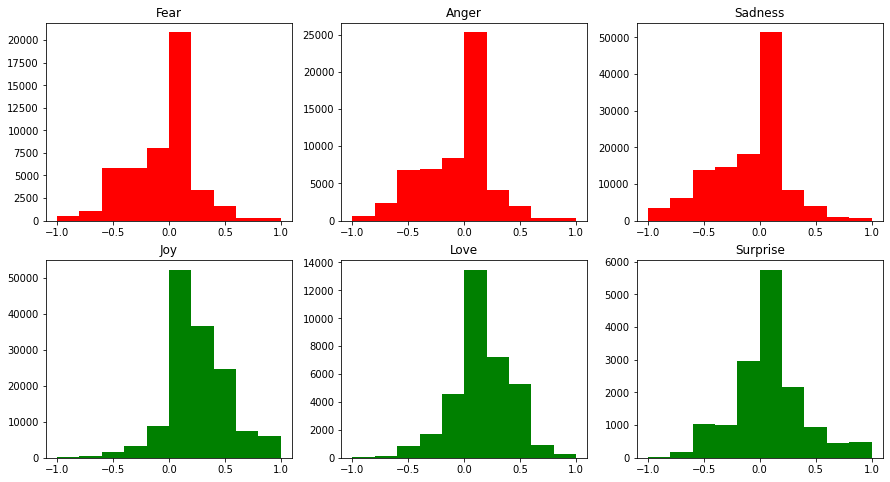

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# Polarity Histogram Plots

fig, ax = plt.subplots(2,3, figsize=(15,8))
plt.figure(figsize=(15,15))
ax[0,0].hist(df_fear['sentiment'], color = 'red')
ax[0,0].set_title("Fear")
ax[0,1].hist(df_anger['sentiment'], color = 'red')
ax[0,1].set_title("Anger")
ax[0,2].hist(df_sadness['sentiment'], color = 'red')
ax[0,2].set_title("Sadness")
ax[1,0].hist(df_joy['sentiment'], color = 'green')
ax[1,0].set_title("Joy")
ax[1,1].hist(df_love['sentiment'], color = 'green')
ax[1,1].set_title("Love")
ax[1,2].hist(df_surprise['sentiment'], color = 'green')
ax[1,2].set_title("Surprise")

plt.show()

**Conclusions**

As we see above, the expected outcomes were met; fear, anger, and sadness all have negative polarity values while joy, love, and surprise have positive sentiment values. 

The one thing I did not expect was how close to 0 each of the values are. 3 of the 6 emotions (fear, anger, and surprised) have values less than 0.1, meaning the sentiment being used is not very polarizing. This is one of the reasons I have limited my expectations for finding fear within real-world articles; language is subjective, and assigning an emotion to a sentence or paragraph will be hard. Despite this, I still expect a reasonable level of accuracy in the Hugingface data. If I do not see the results for fear that I expected (> 60% test accuracy) I will shift the model to look for two (2) classes: **positve or negative**

## **Part 4 - Machine Learning Setup**

For the last portion of this notebook, I'm going to be saving 3 different subsets of this data to be used in the next notebook.

1. The original dataset with all samples.

2. A downsampled dataset where happiness and sadness are downsampled to reasonable levels.

3. A second downsampled dataset where every emotion has 15,000 samples.

### 1. **Original Dataset**

In [ ]:
# Saving the current dataset to the google drive to be used in subsequent notebooks.

save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_full.csv"

with open(save_path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

### 2. **Downsampled Data**

Getting rid of sadness and joy samples to better match other sizes.

In [ ]:
df.emotions.value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

In [ ]:
df_fear = df[df['class']==0]
df_fear.reset_index(inplace = True) #resetting index
df_anger = df[df['class']==1]
df_anger.reset_index(inplace = True) #resetting index
df_sadness = df[df['class']==2]
df_sadness.reset_index(inplace = True) #resetting index
df_joy = df[df['class']==3]
df_joy.reset_index(inplace = True) #resetting index
df_love = df[df['class']==4]
df_love.reset_index(inplace = True) #resetting index
df_surprise = df[df['class']==5]
df_surprise.reset_index(inplace = True)

In [ ]:
# Code for deleting rows in joy dataset

np.random.seed(5) #randomizing the number of rows to be dropped

remove_n = 91067 # to get 50,000 entries for joy, I need to delete 91,067 rows from the joy 

drop_indices = np.random.choice(df_joy.index, remove_n, replace=False)
df_joy_subset = df_joy.drop(drop_indices)


# Code for deleting rows in sadness dataset

np.random.seed(18) #randomizing the number of rows to be dropped

remove_n = 71187 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_sadness.index, remove_n, replace=False)
df_sadness_subset = df_sadness.drop(drop_indices)

# Sanity check to ensure there are now 50,000 entries for both sadness and joy

print("Joy\n"+str(df_joy_subset.shape)+"\nSadness:\n" + str(df_sadness_subset.shape))

Joy
(50000, 13)
Sadness:
(50000, 13)


In [ ]:
# Now that our larger classes have been downsampled, we can concatenate the dataframes back together into a single dataframe.

df_subset = pd.concat([df_fear, df_anger, df_sadness_subset, df_love, df_surprise, df_joy_subset], axis=0)

df_subset = shuffle(df_subset)

In [ ]:
df_subset.emotions.value_counts()

anger       57317
joy         50000
sadness     50000
fear        47712
love        34554
surprise    14972
Name: emotions, dtype: int64

In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_50k.csv"

with open(save_path, 'w', encoding = 'utf-8-sig') as f:
  df_subset.to_csv(f)

### 3. **15K Sample Dataset**

In [ ]:
df_fear = df[df['class']==0]
df_fear.reset_index(inplace = True) #resetting index
df_anger = df[df['class']==1]
df_anger.reset_index(inplace = True) #resetting index
df_sadness = df[df['class']==2]
df_sadness.reset_index(inplace = True) #resetting index
df_joy = df[df['class']==3]
df_joy.reset_index(inplace = True) #resetting index
df_love = df[df['class']==4]
df_love.reset_index(inplace = True) #resetting index
df_surprise = df[df['class']==5]
df_surprise.reset_index(inplace = True)

In [ ]:
# Deleting rows in joy dataset

np.random.seed(2) #randomizing the number of rows to be dropped

remove_n = 126067 # to get 50,000 entries for joy, I need to delete 91,067 rows from the joy 

drop_indices = np.random.choice(df_joy.index, remove_n, replace=False)
df_joy_subset = df_joy.drop(drop_indices)


# Deleting rows in sadness dataset

np.random.seed(99) #randomizing the number of rows to be dropped

remove_n = 106187 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_sadness.index, remove_n, replace=False)
df_sadness_subset = df_sadness.drop(drop_indices)

# Deleting rows in fear dataset

np.random.seed(76) #randomizing the number of rows to be dropped

remove_n = 32712 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_fear.index, remove_n, replace=False)
df_fear_subset = df_fear.drop(drop_indices)

# Deleting rows in anger dataset

np.random.seed(18) #randomizing the number of rows to be dropped

remove_n = 42317 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_anger.index, remove_n, replace=False)
df_anger_subset = df_anger.drop(drop_indices)

# Deleting rows in love dataset

np.random.seed(48) #randomizing the number of rows to be dropped

remove_n = 19554 

drop_indices = np.random.choice(df_love.index, remove_n, replace=False)
df_love_subset = df_love.drop(drop_indices)

In [ ]:
df_subset = pd.concat([df_fear_subset, df_anger_subset, df_sadness_subset, df_love_subset, df_surprise, df_joy_subset], axis=0)

df_subset = shuffle(df_subset)

df_subset.emotions.value_counts()

anger       15000
love        15000
fear        15000
sadness     15000
joy         15000
surprise    14972
Name: emotions, dtype: int64

# **Adding additional stop words**

As noted in the above EDA, there are many common words that appear in many (if not all) emotions within the dataset. To test this in my next step, I'm going to create a dataset with 10 of these additional stopwords to see if there is any impact on a model's accuracy. 

To import this into my next notebook, I will have to do many of the same preprocessing steps as above.

In [ ]:
# Subsetting data so we're only using the 

df_fear = df[df['class']==0]
df_fear.reset_index(inplace = True) #resetting index
df_anger = df[df['class']==1]
df_anger.reset_index(inplace = True) #resetting index
df_sadness = df[df['class']==2]
df_sadness.reset_index(inplace = True) #resetting index
df_joy = df[df['class']==3]
df_joy.reset_index(inplace = True) #resetting index
df_love = df[df['class']==4]
df_love.reset_index(inplace = True) #resetting index
df_surprise = df[df['class']==5]
df_surprise.reset_index(inplace = True)

In [ ]:
# Deleting rows in joy dataset

np.random.seed(2) #randomizing the number of rows to be dropped

remove_n = 126067 # to get 50,000 entries for joy, I need to delete 91,067 rows from the joy 

drop_indices = np.random.choice(df_joy.index, remove_n, replace=False)
df_joy_subset = df_joy.drop(drop_indices)


# Deleting rows in sadness dataset

np.random.seed(99) #randomizing the number of rows to be dropped

remove_n = 106187 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_sadness.index, remove_n, replace=False)
df_sadness_subset = df_sadness.drop(drop_indices)

# Deleting rows in fear dataset

np.random.seed(76) #randomizing the number of rows to be dropped

remove_n = 32712 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_fear.index, remove_n, replace=False)
df_fear_subset = df_fear.drop(drop_indices)

# Deleting rows in anger dataset

np.random.seed(18) #randomizing the number of rows to be dropped

remove_n = 42317 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_anger.index, remove_n, replace=False)
df_anger_subset = df_anger.drop(drop_indices)

# Deleting rows in love dataset

np.random.seed(48) #randomizing the number of rows to be dropped

remove_n = 19554 

drop_indices = np.random.choice(df_love.index, remove_n, replace=False)
df_love_subset = df_love.drop(drop_indices)

In [ ]:
df_subset = pd.concat([df_fear_subset, df_anger_subset, df_sadness_subset, df_love_subset, df_surprise, df_joy_subset], axis=0)

df = shuffle(df_subset)

df.emotions.value_counts()

joy         15000
sadness     15000
love        15000
fear        15000
anger       15000
surprise    14972
Name: emotions, dtype: int64

In [ ]:
df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis = 1)

In [ ]:
# Removing Stop Words 
"""
--------------------------------------
This is where the additional stop words are going to be added. Every successive 
column will contain the original data, and the corresponding data with more stop words.
--------------------------------------
"""

stop_words = set(stopwords.words('english')) # Declaring only english words as the ones that we want to use
stop_words_additional = set(stopwords.words('english')) # Declaring only english words as the ones that we want to use

# Because huggingface has already gotten rid of contractions, I need to add some common contractions WITHOUT the apostrophe so they are still recognized
# NOTE: This will likely not be required in real-world text since the incoming text will not be partially cleaned already.
cont_no_apostrophe = ['dont','id','im','ive','ill','shouldve','couldve','arent','its','itll','itd','thats','thatd','whod','youve','were',
                      'whod','whats','theyre','theres','thered']

cont_no_apostrophe_additional = ['dont','id','im','ive','ill','shouldve','couldve','arent','its','itll','itd','thats','thatd','whod','youve','were',
                      'whod','whats','theyre','theres','thered','feel','go','get','know','think','one','feeling','want','still','really']
# Adding above words to the set
for word in cont_no_apostrophe:
  stop_words.add(word)

for word in cont_no_apostrophe_additional:
  stop_words_additional.add(word)

df['no_stopwords'] = df['tokenized_text'] # Copying our previous step into a new one

# Finally applying a function to remove all of the 
df['no_stopwords'] = df['no_stopwords'].apply(lambda x:[word for word in x if word not in stop_words])



df['no_stopwords_additional'] = df['tokenized_text'] # Copying our previous step into a new one

# Finally applying a function to remove all of the 
df['no_stopwords_additional'] = df['no_stopwords_additional'].apply(lambda x:[word for word in x if word not in stop_words_additional])
# Adding above words to the set


df.head()

,index,text,emotions,tokenized_text,no_stopwords,no_stopwords_additional,class,part_of_speech,pos_stopword,wn_part_of_speech,wn_part_of_speech_stopword,lemmatized,lemmatized_stopword,lemma_string,lemma_string_stopword
7558,22376,i feel that responding to the results of the d...,joy,"[i, feel, that, responding, to, the, results, ...","[feel, responding, results, dice, finding, cle...","[responding, results, dice, finding, clever, j...",3,"[(feel, NN), (responding, VBG), (results, NNS)...","[(feel, NN), (responding, VBG), (results, NNS)...","[(feel, n), (responding, v), (results, n), (di...","[(feel, n), (responding, v), (results, n), (di...","[feel, respond, result, dice, find, clever, ju...","[feel, respond, result, dice, find, clever, ju...",feel respond result dice find clever justifica...,feel respond result dice find clever justifica...
36697,126532,i would never ever ever want to get back with ...,sadness,"[i, would, never, ever, ever, want, to, get, b...","[would, never, ever, ever, want, get, back, so...","[would, never, ever, ever, back, someone, will...",2,"[(would, MD), (never, RB), (ever, RB), (ever, ...","[(would, MD), (never, RB), (ever, RB), (ever, ...","[(would, n), (never, r), (ever, r), (ever, r),...","[(would, n), (never, r), (ever, r), (ever, r),...","[would, never, ever, ever, want, get, back, so...","[would, never, ever, ever, want, get, back, so...",would never ever ever want get back someone wi...,would never ever ever want get back someone wi...
21275,73167,i experience a high level of anxiety and feel ...,sadness,"[i, experience, a, high, level, of, anxiety, a...","[experience, high, level, anxiety, feel, inhib...","[experience, high, level, anxiety, inhibited, ...",2,"[(experience, NN), (high, JJ), (level, NN), (a...","[(experience, NN), (high, JJ), (level, NN), (a...","[(experience, n), (high, a), (level, n), (anxi...","[(experience, n), (high, a), (level, n), (anxi...","[experience, high, level, anxiety, feel, inhib...","[experience, high, level, anxiety, feel, inhib...",experience high level anxiety feel inhibit int...,experience high level anxiety feel inhibit int...
28928,99314,i have the belief that everyone who has been b...,sadness,"[i, have, the, belief, that, everyone, who, ha...","[belief, everyone, born, spirit, feels, gods, ...","[belief, everyone, born, spirit, feels, gods, ...",2,"[(belief, NN), (everyone, NN), (born, VBN), (s...","[(belief, NN), (everyone, NN), (born, VBN), (s...","[(belief, n), (everyone, n), (born, v), (spiri...","[(belief, n), (everyone, n), (born, v), (spiri...","[belief, everyone, bear, spirit, feel, god, pr...","[belief, everyone, bear, spirit, feel, god, pr...",belief everyone bear spirit feel god presence ...,belief everyone bear spirit feel god presence ...
72429,249081,i do remember always feeling like i was too mu...,sadness,"[i, do, remember, always, feeling, like, i, wa...","[remember, always, feeling, like, much, parent...","[remember, always, like, much, parents, hated,...",2,"[(remember, VB), (always, RB), (feeling, VBG),...","[(remember, VB), (always, RB), (feeling, VBG),...","[(remember, v), (always, r), (feeling, v), (li...","[(remember, v), (always, r), (feeling, v), (li...","[remember, always, feel, like, much, parent, h...","[remember, always, feel, like, much, parent, h...",remember always feel like much parent hat much...,remember always feel like much parent hat much...


In [ ]:
df['part_of_speech'] = df['no_stopwords'].apply(nltk.tag.pos_tag) # Using nltk's built in "pos_tag" to add parts of speech for each token (word)
df['pos_stopword'] = df['no_stopwords_additional'].apply(nltk.tag.pos_tag)

In [ ]:
def wordnet_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN 

df['wn_part_of_speech'] = df['part_of_speech'].apply(lambda x: [(word, wordnet_tagger(pos_tag)) for (word, pos_tag) in x])
df['wn_part_of_speech_stopword'] = df['pos_stopword'].apply(lambda x: [(word, wordnet_tagger(pos_tag)) for (word, pos_tag) in x])

In [ ]:
lemmatizer = WordNetLemmatizer()

df['lemmatized'] = df['wn_part_of_speech'].apply(lambda x: [lemmatizer.lemmatize(word, pos) for word, pos in x])
df['lemmatized_stopword'] = df['wn_part_of_speech_stopword'].apply(lambda x: [lemmatizer.lemmatize(word, pos) for word, pos in x])

In [ ]:
df['lemma_string'] = [' '.join(map(str,l)) for l in df['lemmatized']]
df['lemma_string'] = df['lemma_string'].apply(lambda x: str.lower(x))

df['lemma_string_stopword'] = [' '.join(map(str,l)) for l in df['lemmatized_stopword']]
df['lemma_string_stopword'] = df['lemma_string_stopword'].apply(lambda x: str.lower(x))

In [ ]:
# At a first glance, there is not a huge difference in the first few inputs, but I'll try anyway to test this against the standard dataset

df.head()

,index,text,emotions,tokenized_text,no_stopwords,no_stopwords_additional,class,part_of_speech,pos_stopword,wn_part_of_speech,wn_part_of_speech_stopword,lemmatized,lemmatized_stopword,lemma_string,lemma_string_stopword
7558,22376,i feel that responding to the results of the d...,joy,"[i, feel, that, responding, to, the, results, ...","[feel, responding, results, dice, finding, cle...","[responding, results, dice, finding, clever, j...",3,"[(feel, NN), (responding, VBG), (results, NNS)...","[(responding, VBG), (results, NNS), (dice, JJ)...","[(feel, n), (responding, v), (results, n), (di...","[(responding, v), (results, n), (dice, a), (fi...","[feel, respond, result, dice, find, clever, ju...","[respond, result, dice, find, clever, justific...",feel respond result dice find clever justifica...,respond result dice find clever justification ...
36697,126532,i would never ever ever want to get back with ...,sadness,"[i, would, never, ever, ever, want, to, get, b...","[would, never, ever, ever, want, get, back, so...","[would, never, ever, ever, back, someone, will...",2,"[(would, MD), (never, RB), (ever, RB), (ever, ...","[(would, MD), (never, RB), (ever, RB), (ever, ...","[(would, n), (never, r), (ever, r), (ever, r),...","[(would, n), (never, r), (ever, r), (ever, r),...","[would, never, ever, ever, want, get, back, so...","[would, never, ever, ever, back, someone, will...",would never ever ever want get back someone wi...,would never ever ever back someone willing mak...
21275,73167,i experience a high level of anxiety and feel ...,sadness,"[i, experience, a, high, level, of, anxiety, a...","[experience, high, level, anxiety, feel, inhib...","[experience, high, level, anxiety, inhibited, ...",2,"[(experience, NN), (high, JJ), (level, NN), (a...","[(experience, NN), (high, JJ), (level, NN), (a...","[(experience, n), (high, a), (level, n), (anxi...","[(experience, n), (high, a), (level, n), (anxi...","[experience, high, level, anxiety, feel, inhib...","[experience, high, level, anxiety, inhibit, in...",experience high level anxiety feel inhibit int...,experience high level anxiety inhibit interaction
28928,99314,i have the belief that everyone who has been b...,sadness,"[i, have, the, belief, that, everyone, who, ha...","[belief, everyone, born, spirit, feels, gods, ...","[belief, everyone, born, spirit, feels, gods, ...",2,"[(belief, NN), (everyone, NN), (born, VBN), (s...","[(belief, NN), (everyone, NN), (born, VBN), (s...","[(belief, n), (everyone, n), (born, v), (spiri...","[(belief, n), (everyone, n), (born, v), (spiri...","[belief, everyone, bear, spirit, feel, god, pr...","[belief, everyone, bear, spirit, feel, god, pr...",belief everyone bear spirit feel god presence ...,belief everyone bear spirit feel god presence ...
72429,249081,i do remember always feeling like i was too mu...,sadness,"[i, do, remember, always, feeling, like, i, wa...","[remember, always, feeling, like, much, parent...","[remember, always, like, much, parents, hated,...",2,"[(remember, VB), (always, RB), (feeling, VBG),...","[(remember, VB), (always, RB), (like, IN), (mu...","[(remember, v), (always, r), (feeling, v), (li...","[(remember, v), (always, r), (like, n), (much,...","[remember, always, feel, like, much, parent, h...","[remember, always, like, much, parent, hat, mu...",remember always feel like much parent hat much...,remember always like much parent hat much energy


In [ ]:
df = df.drop(columns =['level_0', 'index'])

df.head()

,text,emotions,tokenized_text,no_stopwords,no_stopwords_additional,class,part_of_speech,pos_stopword,wn_part_of_speech,wn_part_of_speech_stopword,lemmatized,lemmatized_stopword,lemma_string,lemma_string_stopword
0,i feel that responding to the results of the d...,joy,"[i, feel, that, responding, to, the, results, ...","[feel, responding, results, dice, finding, cle...","[responding, results, dice, finding, clever, j...",3,"[(feel, NN), (responding, VBG), (results, NNS)...","[(responding, VBG), (results, NNS), (dice, JJ)...","[(feel, n), (responding, v), (results, n), (di...","[(responding, v), (results, n), (dice, a), (fi...","[feel, respond, result, dice, find, clever, ju...","[respond, result, dice, find, clever, justific...",feel respond result dice find clever justifica...,respond result dice find clever justification ...
1,i would never ever ever want to get back with ...,sadness,"[i, would, never, ever, ever, want, to, get, b...","[would, never, ever, ever, want, get, back, so...","[would, never, ever, ever, back, someone, will...",2,"[(would, MD), (never, RB), (ever, RB), (ever, ...","[(would, MD), (never, RB), (ever, RB), (ever, ...","[(would, n), (never, r), (ever, r), (ever, r),...","[(would, n), (never, r), (ever, r), (ever, r),...","[would, never, ever, ever, want, get, back, so...","[would, never, ever, ever, back, someone, will...",would never ever ever want get back someone wi...,would never ever ever back someone willing mak...
2,i experience a high level of anxiety and feel ...,sadness,"[i, experience, a, high, level, of, anxiety, a...","[experience, high, level, anxiety, feel, inhib...","[experience, high, level, anxiety, inhibited, ...",2,"[(experience, NN), (high, JJ), (level, NN), (a...","[(experience, NN), (high, JJ), (level, NN), (a...","[(experience, n), (high, a), (level, n), (anxi...","[(experience, n), (high, a), (level, n), (anxi...","[experience, high, level, anxiety, feel, inhib...","[experience, high, level, anxiety, inhibit, in...",experience high level anxiety feel inhibit int...,experience high level anxiety inhibit interaction
3,i have the belief that everyone who has been b...,sadness,"[i, have, the, belief, that, everyone, who, ha...","[belief, everyone, born, spirit, feels, gods, ...","[belief, everyone, born, spirit, feels, gods, ...",2,"[(belief, NN), (everyone, NN), (born, VBN), (s...","[(belief, NN), (everyone, NN), (born, VBN), (s...","[(belief, n), (everyone, n), (born, v), (spiri...","[(belief, n), (everyone, n), (born, v), (spiri...","[belief, everyone, bear, spirit, feel, god, pr...","[belief, everyone, bear, spirit, feel, god, pr...",belief everyone bear spirit feel god presence ...,belief everyone bear spirit feel god presence ...
4,i do remember always feeling like i was too mu...,sadness,"[i, do, remember, always, feeling, like, i, wa...","[remember, always, feeling, like, much, parent...","[remember, always, like, much, parents, hated,...",2,"[(remember, VB), (always, RB), (feeling, VBG),...","[(remember, VB), (always, RB), (like, IN), (mu...","[(remember, v), (always, r), (feeling, v), (li...","[(remember, v), (always, r), (like, n), (much,...","[remember, always, feel, like, much, parent, h...","[remember, always, like, much, parent, hat, mu...",remember always feel like much parent hat much...,remember always like much parent hat much energy


In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_stopwords.csv"

with open(save_path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)